In [1]:
import pandas as pd
import numpy as np 
import json
import os
import re
import string 
import unicodedata
import warnings 
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

In [2]:
pd.set_option("display.max_colwidth", 200)

%matplotlib inline

In [268]:
df = pd.read_csv('train.csv')

In [269]:
df.shape

(7613, 5)

In [270]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# Data Inspection

In [272]:
df[df['target'] == 0].head(10)

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0
20,31,NaN,NaN,this is ridiculous....,0
21,32,NaN,NaN,London is cool ;),0
22,33,NaN,NaN,Love skiing,0
23,34,NaN,NaN,What a wonderful day!,0
24,36,NaN,NaN,LOOOOOOL,0


In [273]:
df[df['target'] == 1].head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


In [274]:
df["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

# Data Pre-processing

In [275]:
df['hashtags'] = df['text'].str.findall(r'#.*?(?=\s|$)')
df['hashtags'] = df['hashtags'].apply(lambda x: [item for item in x if item != '#'])
df.head()

,id,keyword,location,text,target,hashtags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,[#earthquake]
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,[]
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,[]
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,[#wildfires]
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,"[#Alaska, #wildfires]"


In [276]:
df['mentions'] = df['text'].str.findall(r'@.*?(?=\s|$)')
df['mentions'] = df['mentions'].apply(lambda x: [item for item in x if item != '@'])
df.head()

,id,keyword,location,text,target,hashtags,mentions
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,[#earthquake],[]
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,[],[]
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,[],[]
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,[#wildfires],[]
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,"[#Alaska, #wildfires]",[]


In [277]:
def remove_diacritics(text):
    """
    Returns a string with all diacritics (aka non-spacing marks) removed.
    For example "Héllô" will become "Hello".
    Useful for comparing strings in an accent-insensitive fashion.
    """
    normalized = unicodedata.normalize("NFKD", text)
    return "".join(c for c in normalized if unicodedata.category(c) != "Mn")

In [278]:
def preprocess(text):
    space_pattern = '\s+'
    new_line = '\n+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    non_word_char = '[^\w ]|_'
    html_and= '\bamp\b'
    
    parsed_text = re.sub(space_pattern, ' ', text)
    parsed_text = re.sub(new_line, ' ', parsed_text)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(non_word_char, ' ', parsed_text)
    parsed_text = re.sub(r"\bamp\b", '', parsed_text)
    
    return parsed_text

In [279]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [292]:
df['tidy_tweet'] = np.vectorize(remove_diacritics)(df['text'])
df.head()

,id,keyword,location,text,tidy_tweet
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.","Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all","there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan


In [293]:
df['tidy_tweet'] = np.vectorize(preprocess)(df['tidy_tweet'])

In [294]:
df['tidy_tweet'] = np.vectorize(deEmojify)(df['tidy_tweet'])
df.head()

,id,keyword,location,text,tidy_tweet
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.",Heard about earthquake is different cities stay safe everyone
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",there is a forest fire at spot pond geese are fleeing across the street I cannot save them all
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting Spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan


In [295]:
df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
df['tidy_tweet'] = df['tidy_tweet'].str.strip()

In [296]:
df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x: x.split()) # tokenizing
df.head()

,id,keyword,location,text,tidy_tweet
0,0,NaN,NaN,Just happened a terrible car crash,"[Just, happened, terrible, car, crash]"
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.","[Heard, about, earthquake, is, different, cities, stay, safe, everyone]"
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all","[there, is, forest, fire, at, spot, pond, geese, are, fleeing, across, the, street, cannot, save, them, all]"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,"[Apocalypse, lighting, Spokane, wildfires]"
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,"[Typhoon, Soudelor, kills, 28, in, China, and, Taiwan]"


In [297]:
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')

df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x: [item for item in x if item not in sw_nltk])
df.head()

,id,keyword,location,text,tidy_tweet
0,0,NaN,NaN,Just happened a terrible car crash,"[Just, happened, terrible, car, crash]"
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.","[Heard, earthquake, different, cities, stay, safe, everyone]"
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all","[forest, fire, spot, pond, geese, fleeing, across, street, cannot, save]"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,"[Apocalypse, lighting, Spokane, wildfires]"
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,"[Typhoon, Soudelor, kills, 28, China, Taiwan]"


In [298]:
df.drop(['text', 'keyword', 'location', 'id'], axis = 1, inplace = True)
df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x]))
df.head()

,tidy_tweet
0,Just happened terrible car crash
1,Heard earthquake different cities stay safe everyone
2,forest fire spot pond geese fleeing across street cannot save
3,Apocalypse lighting Spokane wildfires
4,Typhoon Soudelor kills 28 China Taiwan


# Data Visualization

## WordClouds

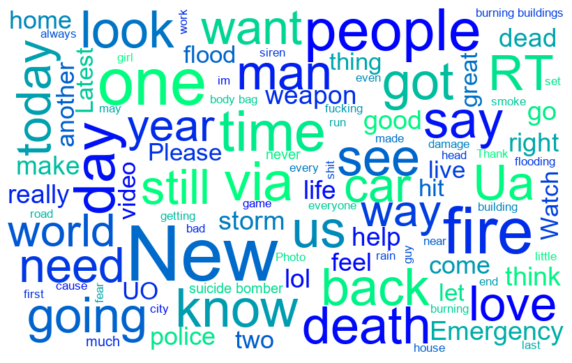

In [240]:
all_words = ' '.join([text for text in df['tidy_tweet']])


wordcloud = WordCloud(font_path='ARIAL.ttf', width=800, height=500, random_state=21,
                      max_font_size=110, background_color = 'white', colormap = 'winter',
                     max_words = 100).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show();

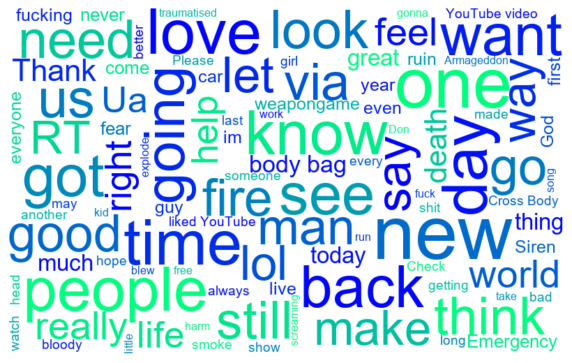

In [241]:
normal_words =' '.join([text for text in df['tidy_tweet'][df['target'] == 0]])


wordcloud = WordCloud(font_path='ARIAL.ttf', width=800, height=500, random_state=21,
                      max_font_size=110, background_color = 'white', colormap = 'winter',
                     max_words = 100).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show();

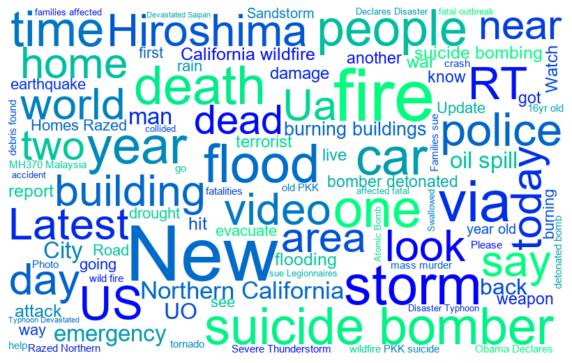

In [242]:
disaster_words =' '.join([text for text in df['tidy_tweet'][df['target'] == 1]])


wordcloud = WordCloud(font_path='ARIAL.ttf', width=800, height=500, random_state=21,
                      max_font_size=110, background_color = 'white', colormap = 'winter',
                     max_words = 100).generate(disaster_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show();

## hashtags

In [243]:
HT_normal = df['hashtags'][df['target'] == 0]
HT_disaster = df['hashtags'][df['target'] == 1]

HT_normal = sum(HT_normal,[])
HT_disaster = sum(HT_disaster,[])

In [244]:
a = nltk.FreqDist(HT_normal)
d = pd.DataFrame({'Hashtag': list(a.keys()), 'Count': list(a.values())})

# selecting top 20 most frequent hashtags
d = d.nlargest(columns="Count", n = 20)
ticks = d.Hashtag.tolist()

    
fig = px.bar(x=ticks, y=d['Count'], title='Normal hashtags', template='plotly_white')
fig.update_layout(
    xaxis = dict(title = 'Hashtags'),
    yaxis = dict(title='Count'),)
fig.show()

In [245]:
a = nltk.FreqDist(HT_disaster)
d = pd.DataFrame({'Hashtag': list(a.keys()), 'Count': list(a.values())})

# selecting top 20 most frequent hashtags
d = d.nlargest(columns="Count", n = 20)
ticks = d.Hashtag.tolist()

    
fig = px.bar(x=ticks, y=d['Count'], title='Disaster hashtags', template='plotly_white')
fig.update_layout(
    xaxis = dict(title = 'Hashtags'),
    xaxis_tickangle=30,
    yaxis = dict(title='Count'),)
fig.show()

## Mentions

In [246]:
M_normal = df['mentions'][df['target'] == 0]
M_disaster = df['mentions'][df['target'] == 1]

M_normal = sum(M_normal,[])
M_disaster = sum(M_disaster,[])

In [247]:
a = nltk.FreqDist(M_normal)
d = pd.DataFrame({'mentions': list(a.keys()), 'Count': list(a.values())})

# selecting top 20 most frequent hashtags
d = d.nlargest(columns="Count", n = 20)
ticks = d.mentions.tolist()

    
fig = px.bar(x=ticks, y=d['Count'], title='Normal Mentions', template='plotly_white')
fig.update_layout(
    xaxis = dict(title = 'Mentions'),
    yaxis = dict(title='Count'),)
fig.show()

In [248]:
a = nltk.FreqDist(M_disaster)
d = pd.DataFrame({'mention': list(a.keys()), 'Count': list(a.values())})

# selecting top 20 most frequent hashtags
d = d.nlargest(columns="Count", n = 20)
ticks = d.mention.tolist()

    
fig = px.bar(x=ticks, y=d['Count'], title='Disaster Mentions', template='plotly_white')
fig.update_layout(
    xaxis = dict(title = 'Mentions'),
    yaxis = dict(title='Count'),)
fig.show()

## Keywords

In [188]:
a = nltk.FreqDist(df['keyword'][df['target']==0])
d = pd.DataFrame({'keyword': list(a.keys()), 'Count': list(a.values())})

# selecting top 20 most frequent hashtags
d = d.nlargest(columns="Count", n = 20)
ticks = d.keyword.tolist()

    
fig = px.bar(x=ticks, y=d['Count'], title='Normal keywords', template='plotly_white')
fig.update_layout(
    xaxis = dict(title = 'Keywords'),
    yaxis = dict(title='Count'),)
fig.show()

In [189]:
a = nltk.FreqDist(df['keyword'][df['target']==1])
d = pd.DataFrame({'keyword': list(a.keys()), 'Count': list(a.values())})

# selecting top 20 most frequent hashtags
d = d.nlargest(columns="Count", n = 20)
ticks = d.keyword.tolist()

    
fig = px.bar(x=ticks, y=d['Count'], title='Normal keywords', template='plotly_white')
fig.update_layout(
    xaxis = dict(title = 'keywords'),
    yaxis = dict(title='Count'),)
fig.show()

In [190]:
df['keyword'].fillna(' ', inplace=True)

In [109]:
def keyword_sentiment(khra):
    count = df[df['keyword'] == khra]['target'].sum()
    total = df[df['keyword'] == khra].shape[0]
    return count/total

In [110]:
keyword_sentiment("accident")

0.6857142857142857

In [111]:
df['keyword_sentiment'] = np.vectorize(keyword_sentiment)(df['keyword'])

df.head()

,id,keyword,location,target,hashtags,mentions,tidy_tweet,keyword_sentiment
0,1,,NaN,1,[#earthquake],[],Our Deeds Reason earthquake May ALLAH Forgive us,0.688525
1,4,,NaN,1,[],[],Forest fire near La Ronge Sask Canada,0.688525
2,5,,NaN,1,[],[],All residents asked shelter place notified officers No evacuation shelter place orders expected,0.688525
3,6,,NaN,1,[#wildfires],[],13 000 people receive wildfires evacuation orders California,0.688525
4,7,,NaN,1,"[#Alaska, #wildfires]",[],Just got sent photo Ruby Alaska smoke wildfires pours school,0.688525


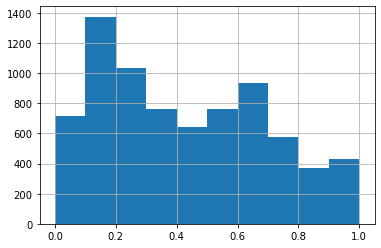

In [115]:
df['keyword_sentiment'].hist();

In [191]:
df.drop(['keyword'], axis= 1, inplace = True)
df

,id,location,target,hashtags,mentions,tidy_tweet
0,1,NaN,1,[#earthquake],[],Our Deeds Reason earthquake May ALLAH Forgive us
1,4,NaN,1,[],[],Forest fire near La Ronge Sask Canada
2,5,NaN,1,[],[],All residents asked shelter place notified officers No evacuation shelter place orders expected
3,6,NaN,1,[#wildfires],[],13 000 people receive wildfires evacuation orders California
4,7,NaN,1,"[#Alaska, #wildfires]",[],Just got sent photo Ruby Alaska smoke wildfires pours school
...,...,...,...,...,...,...
7608,10869,NaN,1,[],[],Two giant cranes holding bridge collapse nearby homes
7609,10870,NaN,1,[],"[@aria_ahrary, @TheTawniest]",aria ahrary TheTawniest The control wild fires California even Northern part state Very troubling
7610,10871,NaN,1,[],[],M1 94 01 04 UTC 5km Volcano Hawaii
7611,10872,NaN,1,[],[],Police investigating bike collided car Little Portugal bike rider suffered serious non life threatening injuries


## Location

# Modelling

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif, chi2

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics


from sklearn.preprocessing import MaxAbsScaler

from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.model_selection import train_test_split

In [287]:
tfidf_vectorizer = TfidfVectorizer(
    use_idf=True,
    decode_error='replace',
    min_df=2,
    max_df=0.9,
    sublinear_tf = True
    )

tfidf = tfidf_vectorizer.fit_transform(df['tidy_tweet']).toarray()
tfidf.shape

(7613, 6533)

In [288]:
transformer = MaxAbsScaler()

In [300]:
X_new_tfidf = transformer.fit_transform(tfidf)

In [252]:
# splitting data into training and validation set
xtrain_tfidf, xtest_tfidf, ytrain, ytest = train_test_split(X_new_tfidf, df['target'], random_state=42, test_size=0.3)

In [253]:
print('training input :', xtrain_tfidf.shape[0])
print('training output :', ytrain.shape[0])
print('testing input :', xtest_tfidf.shape[0])
print('testing output :', ytest.shape[0])

training input : 5329
training output : 5329
testing input : 2284
testing output : 2284


              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1318
           1       0.84      0.65      0.73       966

    accuracy                           0.80      2284
   macro avg       0.81      0.78      0.79      2284
weighted avg       0.81      0.80      0.79      2284

[[1201  117]
 [ 342  624]]


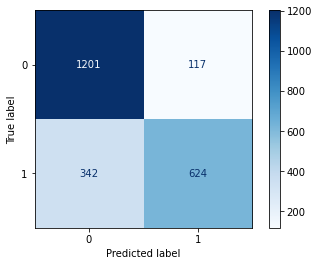

In [254]:
model = svm.SVC().fit(xtrain_tfidf, ytrain)
pred = model.predict(xtest_tfidf)
print(classification_report(ytest, pred))
print(confusion_matrix(ytest, pred))
plot_confusion_matrix(model, xtest_tfidf, ytest, cmap = plt.cm.Blues)  
plt.savefig("file.png");

              precision    recall  f1-score   support

           0       0.80      0.89      0.84      1318
           1       0.82      0.69      0.75       966

    accuracy                           0.80      2284
   macro avg       0.81      0.79      0.79      2284
weighted avg       0.81      0.80      0.80      2284



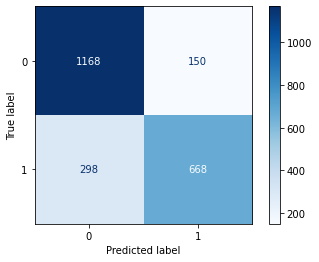

In [255]:
model = LogisticRegression(max_iter = 4000).fit(xtrain_tfidf, ytrain)
pred = model.predict(xtest_tfidf)
print(classification_report(ytest, pred))
plot_confusion_matrix(model, xtest_tfidf, ytest, cmap = plt.cm.Blues)  

In [305]:
df = pd.read_csv('test.csv')
df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [291]:
df.shape

(3263, 4)

In [299]:
tfidf = tfidf_vectorizer.transform(df['tidy_tweet']).toarray()
tfidf.shape

(3263, 6533)

In [301]:
pred_test = model.predict(X_new_tfidf)

In [302]:
pred_testtttt = model.predict(tfidf)

In [308]:
pred_test

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [306]:
df['target'] = pred_test

In [309]:
df.drop(['keyword', 'location', 'text'], axis = 1, inplace = True)
df

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


In [310]:
df.to_csv('submission.csv', index=False)